# Depth Map Alignment and Blending

This notebook demonstrates how to align and blend an outpainted depth map with the original depth map to ensure continuity and smooth transitions. The process involves global brightness/contrast adjustment, translation correction, and bilateral filtering.

In [18]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Load Images
Load the original and outpainted depth maps using the `PIL` library and convert them to grayscale.

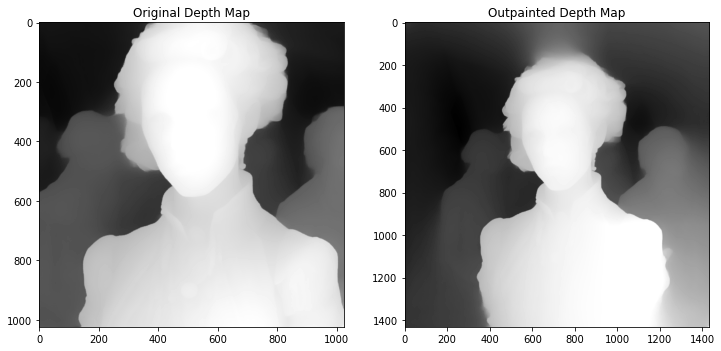

In [19]:
original_depth_map_path = "lady_disparity.png"
outpainted_depth_map_path = "lady_outpainted_disparity.png"

original_depth_map = cv2.imread(original_depth_map_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
outpainted_depth_map = cv2.imread(outpainted_depth_map_path, cv2.IMREAD_UNCHANGED).astype(np.float32)

# Display the original and outpainted depth maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Depth Map")
plt.imshow(original_depth_map, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Outpainted Depth Map")
plt.imshow(outpainted_depth_map, cmap="gray")
plt.show()

## Step 1: Global Brightness/Contrast Adjustment
Adjust the brightness and contrast of the outpainted depth map using histogram matching to better match the original depth map.

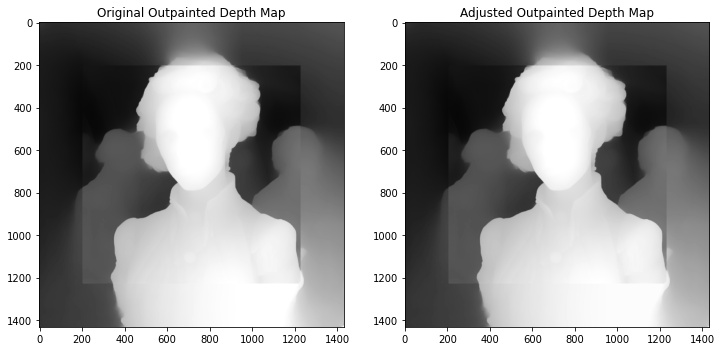

Optimized Contrast: 0.9858947753906252
Optimized Brightness: 6.651306152343751e-05


In [23]:
# Get the dimensions of the original depth map
height_original, width_original = original_depth_map.shape

# Crop the corresponding region from the outpainted depth map
center_y = (outpainted_depth_map.shape[0] - height_original) // 2
center_x = (outpainted_depth_map.shape[1] - width_original) // 2
cropped_outpainted_depth_map = outpainted_depth_map[center_y:center_y + height_original, center_x:center_x + width_original]

# Define the border size as 10% of the original depth map dimensions
border_height = int(0.1 * height_original)
border_width = int(0.1 * width_original)

# Create a mask for the 10% border region
border_mask = np.zeros_like(original_depth_map, dtype=bool)
border_mask[:border_height, :] = True  # Top border
border_mask[-border_height:, :] = True  # Bottom border
border_mask[:, :border_width] = True  # Left border
border_mask[:, -border_width:] = True  # Right border

# Objective function for L1 optimization in the border region
def l1_loss_border(params):
    contrast, brightness = params
    adjusted_cropped = contrast * cropped_outpainted_depth_map + brightness
    # Apply the mask to focus on the border region
    return np.sum(np.abs(original_depth_map[border_mask] - adjusted_cropped[border_mask]))

# Initial guess for contrast and brightness
initial_guess = [1.0, 0.0]

# Perform the optimization
result = minimize(l1_loss_border, initial_guess, method='Nelder-Mead')

# Extract optimized contrast and brightness
optimized_contrast, optimized_brightness = result.x

# Apply the optimized contrast and brightness to the cropped outpainted depth map
equalized_cropped_outpainted_depth_map = optimized_contrast * cropped_outpainted_depth_map + optimized_brightness

# Apply optimized contrast and brightness to the entire outpainted depth map for visualization
adjusted_outpainted_depth_map = optimized_contrast * outpainted_depth_map + optimized_brightness

# Overlay original depth map on the cropped region of the original and adjusted outpainted depth maps
overlay_original = outpainted_depth_map.copy()
overlay_adjusted = adjusted_outpainted_depth_map.copy()

overlay_original[center_y:center_y + height_original, center_x:center_x + width_original] = original_depth_map
overlay_adjusted[center_y:center_y + height_original, center_x:center_x + width_original] = original_depth_map

# Normalize the images for better visualization
overlay_original_normalized = cv2.normalize(overlay_original, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
overlay_adjusted_normalized = cv2.normalize(overlay_adjusted, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Plot the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Outpainted Depth Map")
plt.imshow(overlay_original_normalized, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Adjusted Outpainted Depth Map")
plt.imshow(overlay_adjusted_normalized, cmap='gray')

plt.show()

# Print optimized parameters
print(f"Optimized Contrast: {optimized_contrast}")
print(f"Optimized Brightness: {optimized_brightness}")

## Step 2: Translation Adjustment
Correct any minor misalignment between the original and outpainted depth maps using template matching.

Realignment Values: X Translation = 1 pixels, Y Translation = 0 pixels


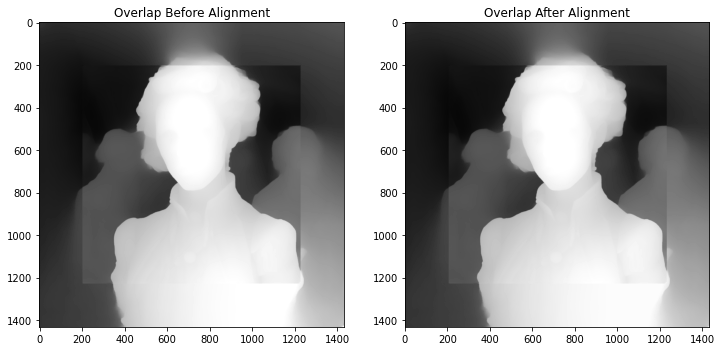

In [28]:
# Show overlap before alignment
overlay_before_alignment = outpainted_depth_map.copy()
overlay_before_alignment[center_y:center_y + height_original, center_x:center_x + width_original] = original_depth_map
overlay_before_alignment_normalized = cv2.normalize(overlay_before_alignment, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Perform template matching for alignment
res = cv2.matchTemplate(adjusted_outpainted_depth_map, original_depth_map, cv2.TM_CCOEFF_NORMED)
_, _, _, max_loc = cv2.minMaxLoc(res)

# Determine translation offsets
top_left = max_loc

# Calculate the realignment values in pixels
translation_y = top_left[1] - center_y
translation_x = top_left[0] - center_x

# Print the realignment values
print(f"Realignment Values: X Translation = {translation_x} pixels, Y Translation = {translation_y} pixels")

# Create a translated version of the adjusted outpainted depth map
translated_outpainted_depth_map = np.zeros_like(adjusted_outpainted_depth_map)
translated_outpainted_depth_map[top_left[1]:top_left[1]+height_original, top_left[0]:top_left[0]+width_original] = original_depth_map

# Copy the translated original depth map back into the adjusted outpainted depth map
aligned_outpainted_depth_map = adjusted_outpainted_depth_map.copy()
aligned_outpainted_depth_map[top_left[1]:top_left[1]+height_original, top_left[0]:top_left[0]+width_original] = translated_outpainted_depth_map[top_left[1]:top_left[1]+height_original, top_left[0]:top_left[0]+width_original]

# Normalize for visualization
overlay_after_alignment = aligned_outpainted_depth_map.copy()
overlay_after_alignment_normalized = cv2.normalize(overlay_after_alignment, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Display overlap after alignment
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Overlap Before Alignment")
plt.imshow(overlay_before_alignment_normalized, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Overlap After Alignment")
plt.imshow(overlay_after_alignment_normalized, cmap='gray')

plt.show()

## Step 3: Bilateral Filtering
Apply bilateral filtering to the translated outpainted depth map to smooth the transitions between the original and outpainted regions.

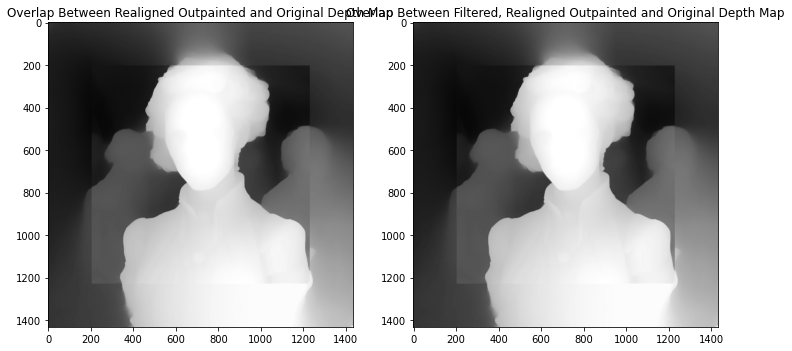

In [29]:
# Apply bilateral filtering to the realigned outpainted depth map
filtered_outpainted_depth_map = cv2.bilateralFilter(aligned_outpainted_depth_map.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

# Ensure the original depth map remains unmodified in the filtered map
filtered_outpainted_depth_map[top_left[1]:top_left[1]+height_original, top_left[0]:top_left[0]+width_original] = original_depth_map

# Normalize for visualization
overlay_filtered_after_alignment = filtered_outpainted_depth_map.copy()
overlay_filtered_after_alignment_normalized = cv2.normalize(overlay_filtered_after_alignment, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Show overlap before and after bilateral filtering
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Overlap Between Realigned Outpainted and Original Depth Map")
plt.imshow(cv2.normalize(aligned_outpainted_depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Overlap Between Filtered, Realigned Outpainted and Original Depth Map")
plt.imshow(overlay_filtered_after_alignment_normalized, cmap='gray')

plt.show()

## Step 4: Combine the Original and Filtered Depth Maps
Combine the original depth map with the filtered outpainted depth map, ensuring that the original depth map is preserved in the center.

In [ ]:
# Insert the original depth map into the center of the filtered outpainted map
center_y = (height_outpainted - height_original) // 2
center_x = (width_outpainted - width_original) // 2
filtered_outpainted_depth_map[center_y:center_y+height_original, center_x:center_x+width_original] = original_depth_map_np

# Display the final combined depth map
plt.figure(figsize=(6, 6))
plt.title("Final Combined Depth Map")
plt.imshow(filtered_outpainted_depth_map, cmap="gray")
plt.show()

## Save the Final Depth Map
Convert the final combined depth map to an image and save it.

In [ ]:
final_depth_map_image = Image.fromarray(filtered_outpainted_depth_map.astype(np.uint8))
final_depth_map_image_path = "/mnt/data/final_depth_map.png"
final_depth_map_image.save(final_depth_map_image_path)